<a href="https://colab.research.google.com/github/kriskalb/flight-delay-prediction/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cartopy
!pip install pyarrow
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.8 MB/s eta 0:00:00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import cartopy.crs as ccrs
import pyarrow.parquet as pq
import os
import numpy as np
import zipfile
import math
import warnings
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import optuna

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

In [4]:
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
local_zip = '/content/drive/MyDrive/Kurs/final_project/inputs/flights.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


In [2]:
flights = pd.read_csv('/tmp/flights.csv')
airports = pd.read_csv('/content/drive/MyDrive/Kurs/final_project/inputs/airports.csv')
airlines = pd.read_csv('/content/drive/MyDrive/Kurs/final_project/inputs/airlines.csv')

# Initial cleaning/feature engineering

In [ ]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [ ]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [ ]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [ ]:
airports.unique()

AttributeError: ignored

In [ ]:
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [ ]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


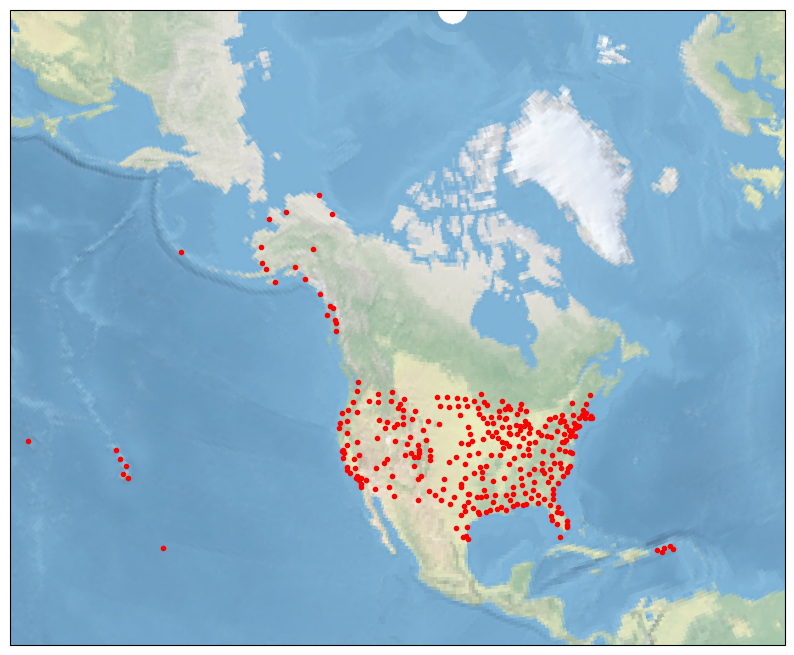

In [ ]:

# Tworzymy mapę w projekcji geograficznej Ameryki Północnej
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-100)})

# Ustalamy granice geograficzne dla Ameryki Północnej
ax.set_extent([-170, -50, 10, 90], ccrs.PlateCarree())

# Zmniejszamy rozmiar znacznika
marker_size = 3

# Dodajemy punkty na mapie
ax.plot(airports['LONGITUDE'], airports['LATITUDE'], 'ro', markersize=marker_size, transform=ccrs.PlateCarree())

# Dodajemy tło mapy
ax.stock_img()

# Wyświetlamy mapę
plt.show()

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    # Promień Ziemi w kilometrach (średni promień)
    radius = 6371.0

    # Zamiana kątów w stopniach na radiany
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Różnice szerokości i długości geograficznych
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Obliczamy odległość za pomocą wzoru Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Obliczamy odległość
    distance = radius * c

    return distance


In [4]:
# Łączenie 'flights' z 'airports' dla 'ORIGIN_AIRPORT'
df = pd.merge(flights, airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']], left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='inner')
new_column_names = {'LATITUDE': 'ORIG_LATITUDE', 'LONGITUDE': 'ORIG_LONGITUDE'}
df = df.rename(columns=new_column_names)
df = df.drop('IATA_CODE', axis=1)

# Łączenie 'flights' z 'airports' dla 'DESTINATION_AIRPORT'
df = pd.merge(df, airports[['IATA_CODE', 'STATE','LATITUDE', 'LONGITUDE']], left_on='DESTINATION_AIRPORT', right_on='IATA_CODE', how='inner')
new_column_names = {'LATITUDE': 'DEST_LATITUDE', 'LONGITUDE': 'DEST_LONGITUDE'}
df = df.rename(columns=new_column_names)
df = df.drop('IATA_CODE', axis=1)


In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,41.0,-4.0,17.0,58.0,204.0,194.0,173.0,1448,451.0,4.0,509,455.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,31.0,-14.0,25.0,56.0,210.0,200.0,171.0,1448,447.0,4.0,515,451.0,-24.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931
3,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,NaN,NaN,NaN,NaN,205.0,NaN,NaN,1448,NaN,NaN,600,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,140.0,-15.0,17.0,157.0,218.0,198.0,170.0,1448,547.0,11.0,633,558.0,-35.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931


In [5]:
df['REAL_DISTANCE'] = df.apply(lambda row: haversine(row['ORIG_LATITUDE'], row['ORIG_LONGITUDE'], row['DEST_LATITUDE'], row['DEST_LONGITUDE']), axis=1)

In [ ]:
df['SCHEDULED_DEPARTURE'].max()

2359

In [19]:
# Backup df
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'

df.to_parquet(parquet_file_path, engine='pyarrow')

In [8]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

Make target feature for classification model

In [7]:
df['ARRIVAL_DELAY_encoded'] = df['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 0 else 0)

Change miles to kilometres


In [9]:
df['DISTANCE'] = df['DISTANCE'].apply(lambda dist: 1.609344*dist)

In [ ]:
df['DISTANCE'].mean()

2131.2896424035225

In [ ]:
df['REAL_DISTANCE'].mean()

1323.4628307063126

In [ ]:
df[df['ARRIVAL_DELAY']>30]['ARRIVAL_DELAY'].value_counts().sum()

600323

In [ ]:
df[df['ARRIVAL_DELAY']>30]['DISTANCE'].mean() - df[df['ARRIVAL_DELAY']>30]['REAL_DISTANCE'].mean()


808.3314484760556

In [ ]:
df['ARRIVAL_DELAY'].mean()

4.885903045804635

In [ ]:
df['ARRIVAL_DELAY'].median()

-5.0

In [ ]:
df['DEPARTURE_DELAY'].mean()

9.774567640166886

In [ ]:
df['DEPARTURE_DELAY'].median()

-1.0

In [ ]:
df[df['DEPARTURE_DELAY']>30]['DISTANCE'].mean() - df[df['DEPARTURE_DELAY']>30]['REAL_DISTANCE'].mean()

824.7261813626171

In [ ]:
df[df['DEPARTURE_DELAY']>15]['ELAPSED_TIME'].mean() - df[df['DEPARTURE_DELAY']>15]['SCHEDULED_TIME'].mean()

-4.514710479747578

In [ ]:
df[df['ARRIVAL_DELAY']>15]['ELAPSED_TIME'].mean() - df[df['ARRIVAL_DELAY']>15]['SCHEDULED_TIME'].mean()

4.00422763621836

In [ ]:
df[df['CANCELLATION_REASON'].notna()].head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE
3,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,NaN,NaN,NaN,NaN,205.0,NaN,NaN,3750.302784,NaN,NaN,600,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
387,2015,1,25,7,AS,106,N767AS,ANC,SEA,2140,NaN,NaN,NaN,NaN,210.0,NaN,NaN,3750.302784,NaN,NaN,210,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
399,2015,1,26,1,AS,82,N577AS,ANC,SEA,1750,NaN,NaN,NaN,NaN,200.0,NaN,NaN,3750.302784,NaN,NaN,2210,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
416,2015,1,27,2,AS,102,N627AS,ANC,SEA,1910,NaN,NaN,NaN,NaN,203.0,NaN,NaN,3750.302784,NaN,NaN,2333,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
460,2015,1,30,5,AS,102,N611AS,ANC,SEA,1910,NaN,NaN,NaN,NaN,203.0,NaN,NaN,3750.302784,NaN,NaN,2333,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164


In [ ]:
df['CANCELLATION_REASON'][df['CANCELLATION_REASON'].notna()].value_counts()

B    47874
A    24309
C    15225
D       22
Name: CANCELLATION_REASON, dtype: int64

In [ ]:
df[df['ARRIVAL_DELAY']>0].head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE
34,2015,1,3,6,AS,108,N413AS,ANC,SEA,45,138.0,53.0,11.0,149.0,204.0,171.0,156.0,3750.302784,525.0,4.0,509,529.0,20.0,0,0,NaN,0.0,0.0,20.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164
36,2015,1,3,6,AS,136,N306AS,ANC,SEA,135,224.0,49.0,8.0,232.0,205.0,180.0,163.0,3750.302784,615.0,9.0,600,624.0,24.0,0,0,NaN,0.0,0.0,0.0,24.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164
37,2015,1,3,6,AS,134,N459AS,ANC,SEA,155,228.0,33.0,13.0,241.0,218.0,188.0,163.0,3750.302784,624.0,12.0,633,636.0,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
46,2015,1,3,6,AS,82,N530AS,ANC,SEA,1750,1759.0,9.0,8.0,1807.0,197.0,202.0,172.0,3750.302784,2159.0,22.0,2207,2221.0,14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
49,2015,1,4,7,AS,98,N317AS,ANC,SEA,5,41.0,36.0,13.0,54.0,205.0,188.0,170.0,3750.302784,444.0,5.0,430,449.0,19.0,0,0,NaN,0.0,0.0,0.0,19.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164


In [ ]:
df['AIR_SYSTEM_DELAY'][df['AIR_SYSTEM_DELAY']>0].value_counts().sum()

532628

In [ ]:
df['AIRLINE_DELAY'][df['AIRLINE_DELAY']>0].value_counts().sum()

538573

In [ ]:
df['WEATHER_DELAY'][df['WEATHER_DELAY']>0].value_counts().sum()

62610

In [ ]:
df['LATE_AIRCRAFT_DELAY'][df['LATE_AIRCRAFT_DELAY']>0].value_counts().sum()

529110

In [10]:
df['most_diverted_destinations'] = df.groupby('DESTINATION_AIRPORT')['DIVERTED'].transform('mean')

In [11]:
df['most_cancelled_origins'] = df.groupby('ORIGIN_AIRPORT')['CANCELLED'].transform('mean')

In [7]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,most_diverted_destinations,most_cancelled_origins
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,2330.330112,404.0,4.0,430,408.0,-22.0,0,0,None,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,41.0,-4.0,17.0,58.0,204.0,194.0,173.0,2330.330112,451.0,4.0,509,455.0,-14.0,0,0,None,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,31.0,-14.0,25.0,56.0,210.0,200.0,171.0,2330.330112,447.0,4.0,515,451.0,-24.0,0,0,None,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748
3,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,NaN,NaN,NaN,NaN,205.0,NaN,NaN,2330.330112,NaN,NaN,600,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,140.0,-15.0,17.0,157.0,218.0,198.0,170.0,2330.330112,547.0,11.0,633,558.0,-35.0,0,0,None,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748


In [12]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

In [13]:
df['most_diverted_dates'] = df.groupby('DATE')['DIVERTED'].transform('mean')
df['most_cancelled_dates'] = df.groupby('DATE')['CANCELLED'].transform('mean')

In [14]:
df_cancelled = df[df['CANCELLED']==1]

In [15]:
df = df[df['CANCELLED']==0]
df = df.drop('CANCELLATION_REASON', axis=1)

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,2330.330112,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,41.0,-4.0,17.0,58.0,204.0,194.0,173.0,2330.330112,451.0,4.0,509,455.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,31.0,-14.0,25.0,56.0,210.0,200.0,171.0,2330.330112,447.0,4.0,515,451.0,-24.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,140.0,-15.0,17.0,157.0,218.0,198.0,170.0,2330.330112,547.0,11.0,633,558.0,-35.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,220,209.0,-11.0,15.0,224.0,200.0,199.0,176.0,2330.330112,620.0,8.0,640,628.0,-12.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164


In [16]:
df_diverted = df[df['DIVERTED']!= 0]

In [17]:
df = df[df['DIVERTED']== 0]

In [15]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,most_diverted_destinations,most_cancelled_origins,DATE,most_diverted_dates,most_cancelled_dates
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,2330.330112,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,41.0,-4.0,17.0,58.0,204.0,194.0,173.0,2330.330112,451.0,4.0,509,455.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,31.0,-14.0,25.0,56.0,210.0,200.0,171.0,2330.330112,447.0,4.0,515,451.0,-24.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,140.0,-15.0,17.0,157.0,218.0,198.0,170.0,2330.330112,547.0,11.0,633,558.0,-35.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,220,209.0,-11.0,15.0,224.0,200.0,199.0,176.0,2330.330112,620.0,8.0,640,628.0,-12.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405


In [18]:
df.isnull().sum()

YEAR                                0
MONTH                               0
DAY                                 0
DAY_OF_WEEK                         0
AIRLINE                             0
FLIGHT_NUMBER                       0
TAIL_NUMBER                         0
ORIGIN_AIRPORT                      0
DESTINATION_AIRPORT                 0
SCHEDULED_DEPARTURE                 0
DEPARTURE_TIME                      0
DEPARTURE_DELAY                     0
TAXI_OUT                            0
WHEELS_OFF                          0
SCHEDULED_TIME                      0
ELAPSED_TIME                        0
AIR_TIME                            0
DISTANCE                            0
WHEELS_ON                           0
TAXI_IN                             0
SCHEDULED_ARRIVAL                   0
ARRIVAL_TIME                        0
ARRIVAL_DELAY                       0
DIVERTED                            0
CANCELLED                           0
AIR_SYSTEM_DELAY              4227770
SECURITY_DEL

In [18]:
columns_to_fill = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

Columns with the time of individual flight stages in float form

In [20]:
for column in ['DEPARTURE_TIME', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'WHEELS_ON', 'WHEELS_OFF']:
  df[column] = df[column].astype(int).astype(str).apply(lambda x: ((4 - len(x))*'0')+str(x))
  df[column] = df[column].apply(lambda x: str(int(x[-2:])*(10/6)))
  df[column] = df[column].astype(float).astype(int)

In [21]:
df['SIN_DEPARTURE_TIME'] = np.sin(2 * np.pi * df['DEPARTURE_TIME'] / 2400)
df['COS_DEPARTURE_TIME'] = np.cos(2 * np.pi * df['DEPARTURE_TIME'] / 2400)
df['SIN_SCHEDULED_DEPARTURE'] = np.sin(2 * np.pi * df['SCHEDULED_DEPARTURE'] / 2400)
df['COS_SCHEDULED_DEPARTURE'] = np.cos(2 * np.pi * df['SCHEDULED_DEPARTURE'] / 2400)
df['SIN_SCHEDULED_ARRIVAL'] = np.sin(2 * np.pi * df['SCHEDULED_ARRIVAL'] / 2400)
df['COS_SCHEDULED_ARRIVAL'] = np.cos(2 * np.pi * df['SCHEDULED_ARRIVAL'] / 2400)
df['SIN_ARRIVAL_TIME'] = np.sin(2 * np.pi * df['ARRIVAL_TIME'] / 2400)
df['COS_ARRIVAL_TIME'] = np.cos(2 * np.pi * df['ARRIVAL_TIME'] / 2400)
df['SIN_WHEELS_ON'] = np.sin(2 * np.pi * df['WHEELS_ON'] / 2400)
df['COS_WHEELS_ON'] = np.cos(2 * np.pi * df['WHEELS_ON'] / 2400)
df['SIN_WHEELS_OFF'] = np.sin(2 * np.pi * df['WHEELS_OFF'] / 2400)
df['COS_WHEELS_OFF'] = np.cos(2 * np.pi * df['WHEELS_OFF'] / 2400)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5231130 entries, 0 to 5332913
Data columns (total 36 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             float64
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [ ]:
df.isna().sum()

YEAR                          0
MONTH                         0
DAY                           0
DAY_OF_WEEK                   0
AIRLINE                       0
FLIGHT_NUMBER                 0
TAIL_NUMBER                   0
ORIGIN_AIRPORT                0
DESTINATION_AIRPORT           0
SCHEDULED_DEPARTURE           0
DEPARTURE_TIME                0
DEPARTURE_DELAY               0
TAXI_OUT                      0
WHEELS_OFF                    0
SCHEDULED_TIME                0
ELAPSED_TIME                  0
AIR_TIME                      0
DISTANCE                      0
WHEELS_ON                     0
TAXI_IN                       0
SCHEDULED_ARRIVAL             0
ARRIVAL_TIME                  0
ARRIVAL_DELAY                 0
DIVERTED                      0
CANCELLED                     0
AIR_SYSTEM_DELAY              0
SECURITY_DELAY                0
AIRLINE_DELAY                 0
LATE_AIRCRAFT_DELAY           0
WEATHER_DELAY                 0
ORIG_LATITUDE              4561
ORIG_LON

In [22]:
df['SIN_DAY_OF_WEEK'] = np.sin(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['COS_DAY_OF_WEEK'] = np.cos(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['SIN_MONTH'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['COS_MONTH'] = np.cos(2 * np.pi * df['MONTH'] / 12)

In [25]:
df = df.dropna()

In [26]:
# Backup df
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'

df.to_parquet(parquet_file_path, engine='pyarrow')

In [2]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [ ]:
df.groupby('AIRLINE')[['ARRIVAL_DELAY']].mean().sort_values(by='ARRIVAL_DELAY', ascending=False)

,ARRIVAL_DELAY
AIRLINE,
NK,15.225780
F9,13.758930
MQ,7.316540
EV,6.980759
B6,6.949339
OO,6.221438
UA,6.211316
VX,4.979539
WN,4.845657


In [23]:
airline_company_names = {
    'NK': 0,
    'F9': 1,
    'MQ': 2,
    'EV': 3,
    'B6': 4,
    'OO': 5,
    'UA': 6,
    'VX': 7,
    'WN': 8,
    'AA': 9,
    'US': 10,
    'HA': 11,
    'DL': 12,
    'AS': 13
}
df['AIRLINE_encoded'] = df['AIRLINE'].map(airline_company_names).astype(int)

In [27]:
df['SIZE_OF_DESTIN_AIRPORT'] = pd.qcut(df.groupby('DESTINATION_AIRPORT')['DESTINATION_AIRPORT'].transform('count'), q=10, labels=False)

In [28]:
df['SIZE_OF_ORIGIN_AIRPORT'] = pd.qcut(df.groupby('ORIGIN_AIRPORT')['ORIGIN_AIRPORT'].transform('count'), q=10, labels=False)

In [29]:
columns_to_encode = ['SECURITY_DELAY', 'AIR_SYSTEM_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
for column in  columns_to_encode:
  new_column_name = column + '_encoded'
  df[new_column_name] = df[column].apply(lambda col: 1 if col>0 else 0).astype(int)

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1


In [30]:
# Backup df
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'

df.to_parquet(parquet_file_path, engine='pyarrow')

In [31]:
# Backup df_cancelled
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_cancelled.parquet'

df_cancelled.to_parquet(parquet_file_path, engine='pyarrow')

In [32]:
# Backup df_diverted
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_diverted.parquet'

df_diverted.to_parquet(parquet_file_path, engine='pyarrow')

In [5]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,...,0.866025,2015-01-01,12,6,0,0,0,0,0,1
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5222000 entries, 0 to 5332913
Data columns (total 64 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   YEAR                         int64         
 1   MONTH                        int64         
 2   DAY                          int64         
 3   DAY_OF_WEEK                  int64         
 4   AIRLINE                      object        
 5   FLIGHT_NUMBER                int64         
 6   TAIL_NUMBER                  object        
 7   ORIGIN_AIRPORT               object        
 8   DESTINATION_AIRPORT          object        
 9   SCHEDULED_DEPARTURE          int64         
 10  DEPARTURE_TIME               int64         
 11  DEPARTURE_DELAY              float64       
 12  TAXI_OUT                     float64       
 13  WHEELS_OFF                   int64         
 14  SCHEDULED_TIME               float64       
 15  ELAPSED_TIME                 float64       
 16  

In [32]:
list(df.columns)

['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY',
 'ORIG_LATITUDE',
 'ORIG_LONGITUDE',
 'DEST_LATITUDE',
 'DEST_LONGITUDE',
 'REAL_DISTANCE',
 'most_diverted_destinations',
 'most_cancelled_origins',
 'DATE',
 'most_diverted_dates',
 'most_cancelled_dates',
 'SIN_DEPARTURE_TIME',
 'COS_DEPARTURE_TIME',
 'SIN_SCHEDULED_DEPARTURE',
 'COS_SCHEDULED_DEPARTURE',
 'SIN_SCHEDULED_ARRIVAL',
 'COS_SCHEDULED_ARRIVAL',
 'SIN_ARRIVAL_TIME',
 'COS_ARRIVAL_TIME',
 'SIN_WHEELS_ON',
 'COS_WHEELS_ON',
 'SIN_WHEELS_OFF',
 'COS_WHEELS_OFF',
 'SIN_DAY_OF_WEEK',
 'COS_D

# First model

## Regression (with 'DEPARTURE_DELAY' feature)



In [6]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'REAL_DISTANCE',
                    'DEPARTURE_DELAY',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                    'SIZE_OF_ORIGIN_AIRPORT']

In [35]:
len(selected_columns)

24

In [7]:
df_selected = df[selected_columns]
X = df[selected_columns]
y = df['ARRIVAL_DELAY']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEPARTURE_DELAY', 'DEST_LATITUDE', 'DEST_LONGITUDE']
scaler = StandardScaler()
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [9]:
model=Ridge(alpha=0.1)
model.fit(X_train, y_train)

Ridge(alpha=0.1)

In [10]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [11]:
r2_lintrain = r2_score(y_train,y_pred_train)

mse_lin = mean_squared_error(y_test,y_pred)
print(f"R2_score (train): {r2_lintrain}")
print(f"Mean Squared Error: {mse_lin}")

R2_score (train): 0.9012258164188304
Mean Squared Error: 155.47301940579504


In [12]:
model.coef_

array([-1.50797152e-02, -1.95348566e+01,  1.58105498e+01,  2.83533655e-01,
        1.93110597e+00, -8.70002659e-02, -2.05376638e+00,  1.70784774e-03,
        3.72297295e+01, -7.71403322e+00, -5.49956324e+01, -5.84911639e-01,
       -4.34095293e+00,  3.18654946e-02, -5.90138665e-01,  6.02596760e-01,
        1.76648819e-01, -2.90374158e-01,  2.03040976e-01,  1.31081847e+01,
        3.70868545e+01,  1.96541167e+00,  3.13969485e+02,  1.55582314e+01,
       -4.83136192e-02])

## Classification (without 'DEPARTURE_DELAY' feature)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [15]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'REAL_DISTANCE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                    'SIZE_OF_ORIGIN_AIRPORT']

In [16]:
X = df[selected_columns]
y = df['ARRIVAL_DELAY_encoded']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE']
scaler = StandardScaler()
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [18]:
model = LogisticRegression(penalty='l2', C=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.628425890463424


In [20]:
classification_rep = classification_report(y_test, y_pred)
print("Classification report:")
print(classification_rep)

Classification report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77    655771
           1       0.62      0.00      0.01    388629

    accuracy                           0.63   1044400
   macro avg       0.63      0.50      0.39   1044400
weighted avg       0.63      0.63      0.49   1044400



# Feature engineering

In [ ]:
df_selected.sample(5)

,DAY,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT
4668147,29,-4.0,135.0,1504.736640,33.43417,-112.00806,36.19837,-95.88824,1501.429165,0.171929,0.985109,0.235990,0.971755,0.974928,-0.222521,-1.000000e+00,-1.836970e-16,8,1,0,7
204583,5,-11.0,220.0,2317.455360,41.97960,-87.90446,33.43417,-112.00806,2313.178992,0.151261,0.988494,0.065403,0.997859,0.433884,-0.900969,-8.660254e-01,-5.000000e-01,1,7,0,8
475739,15,-6.0,47.0,262.323072,19.73877,-156.04563,21.31869,-157.92241,262.782228,0.164187,0.986429,0.107132,0.994245,0.974928,-0.222521,-2.449294e-16,1.000000e+00,11,2,0,1
2469296,29,-5.0,70.0,328.306176,27.97547,-82.53325,25.79325,-80.29056,329.150736,0.235990,0.971755,0.020942,0.999781,-0.433884,-0.900969,5.000000e-01,8.660254e-01,9,3,0,3
660465,3,25.0,146.0,1429.097472,39.85841,-104.66700,41.97960,-87.90446,1425.657403,0.065403,0.997859,0.177085,0.984196,-0.781831,0.623490,5.000000e-01,8.660254e-01,6,8,0,8


In [ ]:
df['ARRIVAL_DELAY'].median()

-5.0

In [ ]:
df[df['DATE'] == '2015-12-23']['ARRIVAL_DELAY'].median()

5.0

In [ ]:
median_per_day = df.groupby(df['DATE'].dt.date)['ARRIVAL_DELAY'].median().sort_values()
median_per_day[median_per_day>0]

DATE
2015-12-26     1.0
2015-01-02     1.0
2015-06-15     1.0
2015-05-18     1.0
2015-04-10     1.0
2015-04-09     1.0
2015-03-05     1.0
2015-03-06     1.0
2015-02-17     2.0
2015-12-22     2.0
2015-07-18     2.0
2015-08-20     2.0
2015-02-16     3.0
2015-12-28     3.0
2015-06-18     3.0
2015-02-22     3.0
2015-03-02     4.0
2015-01-05     4.0
2015-03-03     4.0
2015-01-12     4.0
2015-01-06     4.0
2015-12-23     5.0
2015-02-26     5.0
2015-12-27     6.0
2015-12-29     6.0
2015-03-01     7.0
2015-12-30     9.0
2015-01-03    11.0
2015-01-04    14.0
Name: ARRIVAL_DELAY, dtype: float64

DATE

* 2015-12-26     1.0  holiday
* 2015-01-02     1.0  holiday
* 2015-06-15     1.0
* 2015-05-18     1.0
* 2015-04-10     1.0
* 2015-04-09     1.0
* 2015-03-05     1.0  extreme weather
* 2015-03-06     1.0  extreme weather
* 2015-02-17     2.0  extreme weather
* 2015-12-22     2.0  holiday
* 2015-07-18     2.0
* 2015-08-20     2.0  
* 2015-02-16     3.0  extreme weather
* 2015-12-28     3.0  holiday
* 2015-06-18     3.0  extreme weather
* 2015-02-22     3.0  holiday
* 2015-03-02     4.0  extreme weather
* 2015-01-05     4.0  holiday
* 2015-03-03     4.0  extreme weather
* 2015-01-12     4.0  holiday
* 2015-01-06     4.0  holiday
* 2015-12-23     5.0  holiday
* 2015-02-26     5.0  holiday
* 2015-12-27     6.0  holiday
* 2015-12-29     6.0  holiday
* 2015-03-01     7.0  extreme weather
* 2015-12-30     9.0  holiday
* 2015-01-03    11.0  holiday
* 2015-01-04    14.0  holiday

In [ ]:
df['DATE'].value_counts().sum()

5221218

In [ ]:
df['DATE'].value_counts()[:40].sum()

685056

In [ ]:
top_df_dates = median_per_day.index

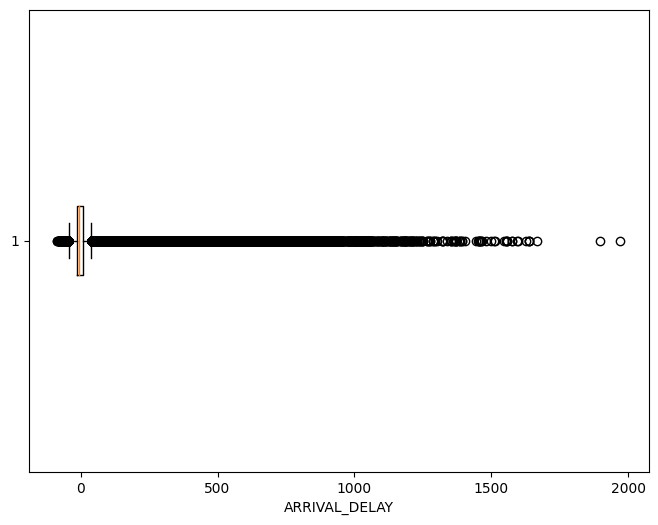

In [ ]:
plt.figure(figsize=(8, 6))  # Opcjonalnie: dostosuj rozmiar wykresu
plt.boxplot(df['DEPARTURE_DELAY'], vert=False)  # vert=False oznacza poziomy wykres pudełkowy

# Dodanie etykiety do osi X
plt.xlabel('DEPARTURE_DELAY')

# Wyświetlenie wykresu
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))  # Opcjonalnie: dostosuj rozmiar wykresu
plt.boxplot(df['ARRIVAL_DELAY'], vert=False)  # vert=False oznacza poziomy wykres pudełkowy

# Dodanie etykiety do osi X
plt.xlabel('ARRIVAL_DELAY')

# Wyświetlenie wykresu
plt.show()

In [45]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,most_diverted_destinations,most_cancelled_origins,DATE,most_diverted_dates,most_cancelled_dates,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SIZE_OF_ORIGIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,12,6,1,0,0,0,0,0
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0


Sprawdzam ile było przypadków kiedy opóźnienie trwało ponad 12h i usuwam te outliers

In [46]:
df[df['ARRIVAL_DELAY']>730]['ARRIVAL_DELAY'].count()

779

In [3]:
df_delayed12h = df[df['ARRIVAL_DELAY']>=730]

In [4]:
df = df[df['ARRIVAL_DELAY']<730]

In [ ]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
df.to_parquet(parquet_file_path, engine='pyarrow')
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_cancelled.parquet'
df_cancelled.to_parquet(parquet_file_path, engine='pyarrow')
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_diverted.parquet'
df_diverted.to_parquet(parquet_file_path, engine='pyarrow')

In [2]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,1
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,1
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,1
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,1
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,1


# Second model

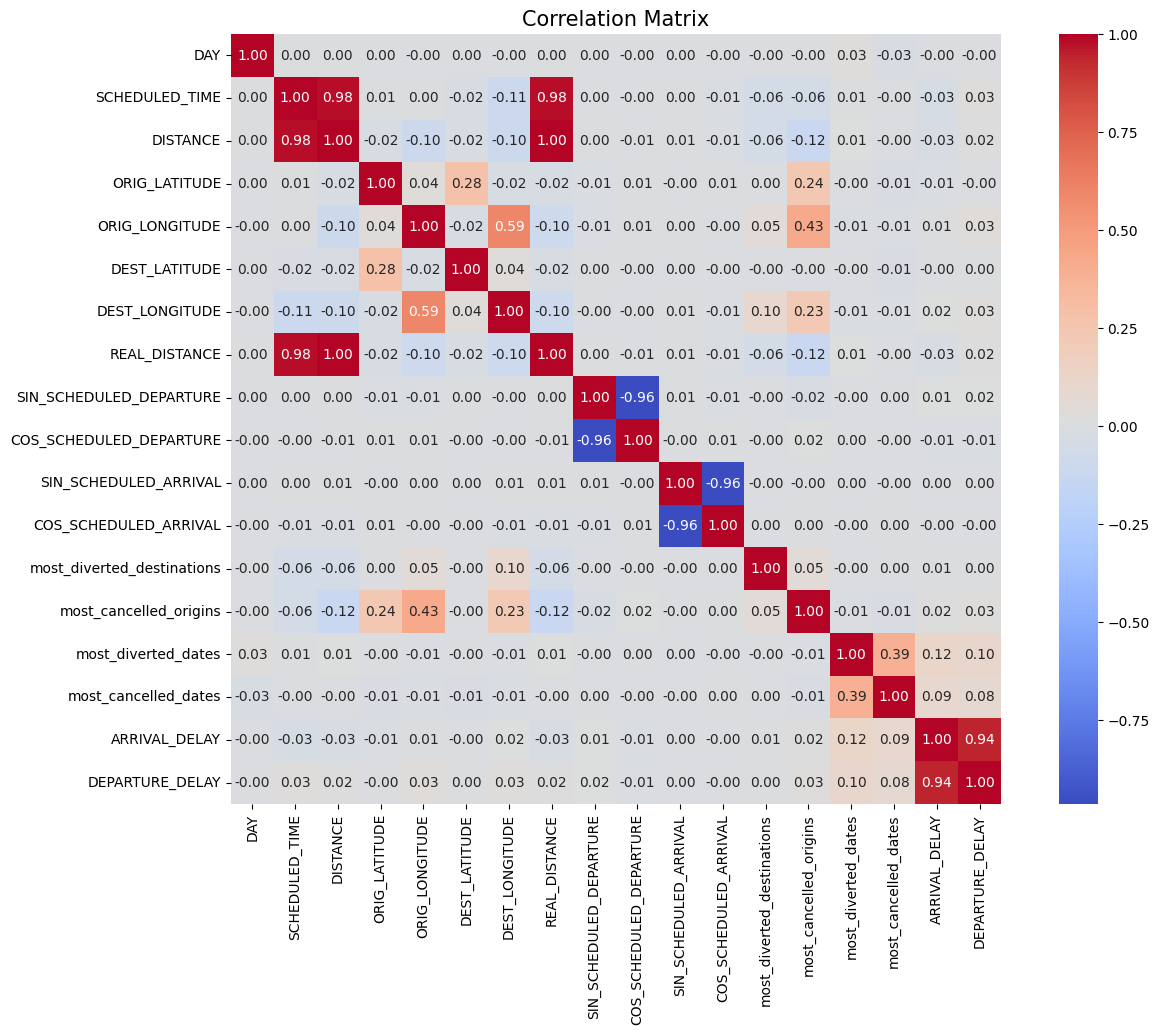

In [4]:
labels_to_corr = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'REAL_DISTANCE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                  'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                  'ARRIVAL_DELAY',
                  'DEPARTURE_DELAY']

corr_df = df[labels_to_corr].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title("Correlation Matrix", fontsize=15)
plt.show()

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,0
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0


In [5]:
group_0_weather = df[df['WEATHER_DELAY_encoded'] == 0]['ARRIVAL_DELAY']
group_1_weather = df[df['WEATHER_DELAY_encoded'] == 1]['ARRIVAL_DELAY']

# Test t-STUDENT

t_statistic, p_value = ttest_ind(group_0_weather, group_1_weather)
print(f"Test t-studenta - weather:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")


Test t-studenta - weather:
t-statistic: -556.3914487897043
p-value: 0.0


Wartości t-statystyki są bardzo niskie, co wskazuje na duże różnice między grupami, a p-wartości są bliskie zeru (<0.05), co oznacza, że różnice te są istotne statystycznie.

In [6]:
# Tworzenie grup na podstawie zmiennej kategorycznej
grouped_data = [df['ARRIVAL_DELAY'][df['SIZE_OF_ORIGIN_AIRPORT'] == i] for i in df['SIZE_OF_ORIGIN_AIRPORT'].unique()]
f_statistic, p_value = f_oneway(*grouped_data)
print('SIZE_OF_ORIGIN_AIRPORT:')
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

grouped_data = [df['ARRIVAL_DELAY'][df['SIZE_OF_DESTIN_AIRPORT'] == i] for i in df['SIZE_OF_DESTIN_AIRPORT'].unique()]
f_statistic, p_value = f_oneway(*grouped_data)
print('SIZE_OF_DESTIN_AIRPORT:')
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

grouped_data = [df['ARRIVAL_DELAY'][df['AIRLINE_encoded'] == i] for i in df['AIRLINE_encoded'].unique()]
f_statistic, p_value = f_oneway(*grouped_data)
print('AIRLINE_encoded:')
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")



SIZE_OF_ORIGIN_AIRPORT:
F-statistic: 700.9514243307518
P-value: 0.0
SIZE_OF_DESTIN_AIRPORT:
F-statistic: 378.8956244081768
P-value: 0.0
AIRLINE_encoded:
F-statistic: 2481.110964795245
P-value: 0.0


Wszystkie te wyniki sugerują, że te zmienne kategoryczne mają wpływ na zmienną numeryczną ARRIVAL_DELAY, a różnice między grupami tych zmiennych są istotne statystycznie. Innymi słowy, te zmienne kategoryczne mają wpływ na opóźnienia przyjazdu w analizowanych danych.

In [3]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'SIZE_OF_ORIGIN_AIRPORT',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                    ]

In [5]:
df_sampled = df.sample(50000).copy()
X = df_sampled[selected_columns]
y = df_sampled['ARRIVAL_DELAY']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE']
# scaler = StandardScaler()
# X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
# X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [7]:
def objective(trial):

    max_depth = trial.suggest_int('max_depth', 8, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 8, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 8, 20)

    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [8]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-09-26 16:57:40,497] A new study created in memory with name: no-name-e4423fd4-b419-40ea-a10d-c6bf5ad83aba
[I 2023-09-26 16:58:20,408] Trial 0 finished with value: 1313.613907878302 and parameters: {'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 13}. Best is trial 0 with value: 1313.613907878302.
[I 2023-09-26 16:59:19,455] Trial 1 finished with value: 1279.1079244491286 and parameters: {'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 15}. Best is trial 1 with value: 1279.1079244491286.
[W 2023-09-26 17:00:37,708] Trial 2 failed with parameters: {'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 19} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-7-61a96483c147>", line 14, in objective
    model.fit(X_train, y_train)
  File "/usr/local/lib/python

KeyboardInterrupt: ignored

In [ ]:
best_params = study.best_params

In [9]:
best_model_tree = DecisionTreeRegressor(random_state=42, max_depth=13, min_samples_split=16, min_samples_leaf=15)

In [10]:
best_model_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=13, min_samples_leaf=15, min_samples_split=16,
                      random_state=42)

In [11]:
y_pred_train = best_model_tree.predict(X_train)
y_pred = best_model_tree.predict(X_test)

In [12]:
mse = mean_squared_error(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)

In [13]:
print(f"R2_score (train): {r2_train}")
print(f"Mean Squared Error: {mse}")

R2_score (train): 0.137209683104922
Mean Squared Error: 1279.1079244491286


In [14]:
mae = mean_absolute_error(y_test, y_pred)

In [15]:
mae

19.929687073342187

# Feature Enginnering

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,0
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0


In [ ]:
df.groupby(df['ORIGIN_AIRPORT'])['ARRIVAL_DELAY'].median().sort_values(ascending=False).index

Index(['GST', 'ADK', 'PPG', 'ILG', 'AKN', 'OME', 'STC', 'RHI', 'ITH', 'COD',
       ...
       'DLG', 'LSE', 'TOL', 'VEL', 'DIK', 'LAR', 'PSE', 'BTM', 'HYA', 'CNY'],
      dtype='object', name='ORIGIN_AIRPORT', length=319)

In [40]:
origin_airports_to_encode = list(df.groupby(df['ORIGIN_AIRPORT'])['ARRIVAL_DELAY'].median().sort_values(ascending=False).index)

In [41]:
origin_airports_mapping = {}

for i, airport in enumerate(origin_airports_to_encode):
    origin_airports_mapping[airport] = i

In [42]:
df['ORIGIN_AIRPORT_RANK'] = df['ORIGIN_AIRPORT'].map(origin_airports_mapping).astype(int)

In [43]:
destin_airports_to_encode = list(df.groupby(df['DESTINATION_AIRPORT'])['ARRIVAL_DELAY'].median().sort_values(ascending=False).index)

In [44]:
destin_airports_mapping = {}


for i, airport in enumerate(destin_airports_to_encode):
    destin_airports_mapping[airport] = i

In [45]:
df['DESTIN_AIRPORT_RANK'] = df['DESTINATION_AIRPORT'].map(destin_airports_mapping).astype(int)

In [ ]:
df.groupby(df['AIRLINE'])['DISTANCE'].median().sort_values()

AIRLINE
HA     262.323072
MQ     585.801216
EV     690.408576
OO     704.892672
WN    1010.668032
DL    1039.636224
US    1047.682944
F9    1440.362880
AS    1535.314176
NK    1540.142208
AA    1577.157120
B6    1627.046784
UA    1713.951360
VX    2222.504064
Name: DISTANCE, dtype: float64

In [46]:
airlines_to_encode_by_distance = list(df.groupby(df['AIRLINE'])['DISTANCE'].median().sort_values().index)

In [47]:
airlines_by_distance_mapping = {}

for i, airline in enumerate(airlines_to_encode_by_distance):
    airlines_by_distance_mapping[airline] = i

In [48]:
df['AIRLINES_BY_DISTANCE'] = df['AIRLINE'].map(airlines_by_distance_mapping).astype(int)

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS,ORIGIN_AIRPORT_RANK,DESTIN_AIRPORT_RANK,AIRLINES_BY_DISTANCE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,0,137,195,5
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8


In [49]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
df.to_parquet(parquet_file_path, engine='pyarrow')

In [2]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS,ORIGIN_AIRPORT_RANK,DESTIN_AIRPORT_RANK,AIRLINES_BY_DISTANCE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,0,137,195,5
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8


# Third model

In [40]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'SIZE_OF_ORIGIN_AIRPORT',
                    'ORIGIN_AIRPORT_RANK',
                    'DESTIN_AIRPORT_RANK',
                    'AIRLINES_BY_DISTANCE',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',]

In [41]:
df_sampled = df.sample(500000).copy()
X = df[selected_columns]
y = df['ARRIVAL_DELAY']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'ORIGIN_AIRPORT_RANK', 'DESTIN_AIRPORT_RANK']
# scaler = StandardScaler()
# X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
# X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [43]:
def objective(trial):

    max_depth = trial.suggest_int('max_depth', 8, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 8, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 8, 20)
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [44]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-09-26 17:57:06,029] A new study created in memory with name: no-name-11fbc65c-fcad-4f32-8ebd-857d9932cf6b
[I 2023-09-26 17:57:16,295] Trial 0 finished with value: 1413.3817042881783 and parameters: {'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 15}. Best is trial 0 with value: 1413.3817042881783.
[I 2023-09-26 17:57:21,512] Trial 1 finished with value: 1393.7751312986854 and parameters: {'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 15}. Best is trial 1 with value: 1393.7751312986854.
[I 2023-09-26 17:57:29,119] Trial 2 finished with value: 1364.8619548164074 and parameters: {'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 15}. Best is trial 2 with value: 1364.8619548164074.
[I 2023-09-26 17:57:38,574] Trial 3 finished with value: 1432.0411630000838 and parameters: {'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 10}. Best is trial 2 with value: 1364.8619548164074.
[I 2023-09-26 17:57:44,094] Trial 4 finished with value

In [ ]:
best_params = study.best_params
best_model_tree = DecisionTreeRegressor(random_state=42, **best_params)
best_model_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=19, min_samples_split=17,
                      random_state=42)

In [ ]:
y_pred_train = best_model_tree.predict(X_train)
y_pred = best_model_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
mae = mean_absolute_error(y_test, y_pred)
print(f"R2_score: {r2}")
print(f"R2_score (train): {r2_train}")
print(f"Mean Squared Error: {mse}")
print(f"Mean absolute Error: {mae}")

R2_score: 0.0854728294616457
R2_score (train): 0.08618393388076717
Mean Squared Error: 1329.0077774808672
Mean absolute Error: 20.436286018215796


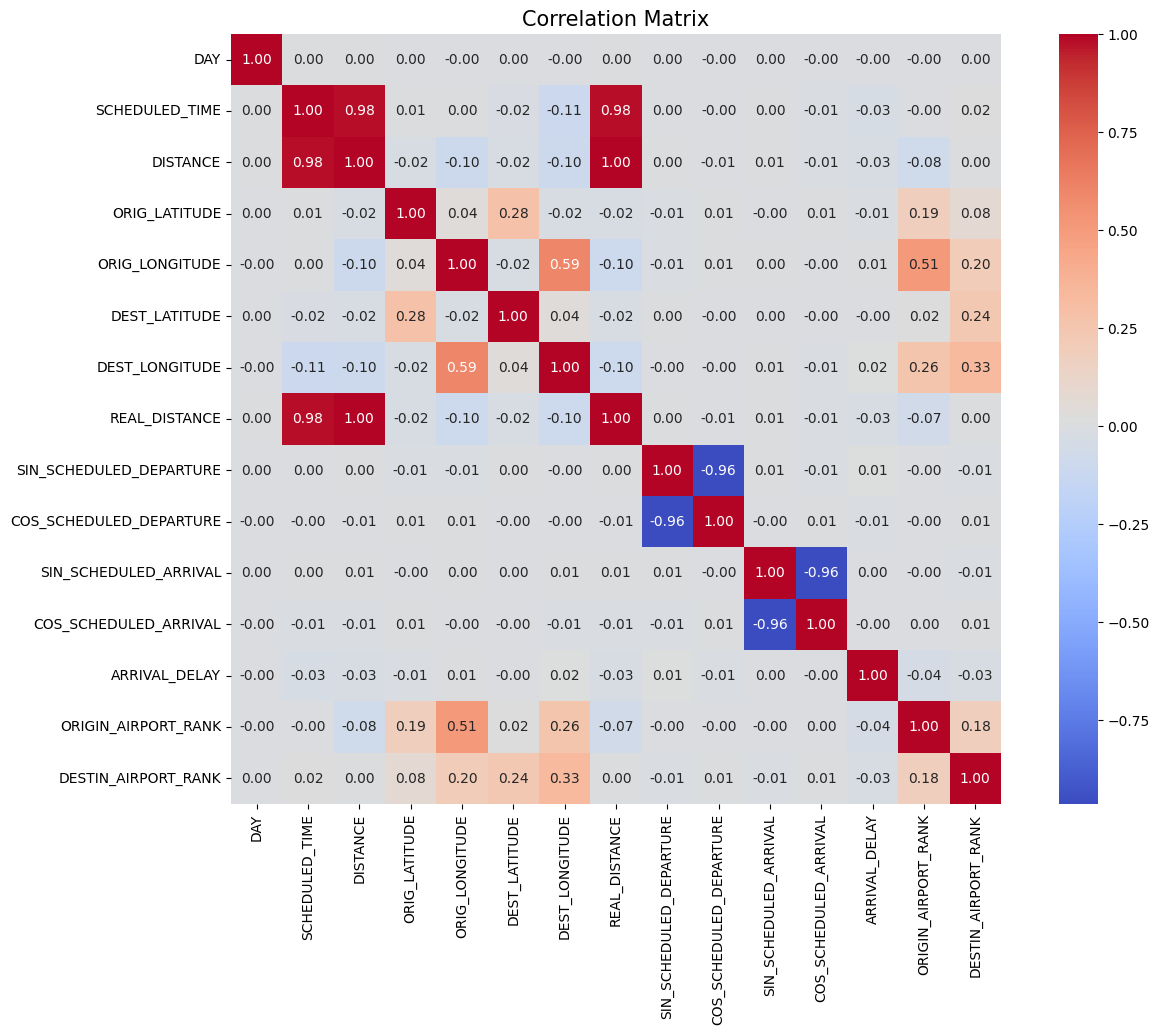

In [ ]:
labels_to_corr = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'REAL_DISTANCE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'ARRIVAL_DELAY',
                    'ORIGIN_AIRPORT_RANK',
                    'DESTIN_AIRPORT_RANK',
                    ]

corr_df = df[labels_to_corr].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title("Correlation Matrix", fontsize=15)
plt.show()

In [ ]:
model=Ridge(alpha=1)
model.fit(X_train, y_train)

Ridge(alpha=1)

In [ ]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
r2_lin = r2_score(y_test,y_pred)
r2_lintrain = r2_score(y_train,y_pred_train)

mse_lin = mean_squared_error(y_test,y_pred)
print(f"R2_score: {r2_lin}")
print(f"R2_score (train): {r2_lintrain}")
print(f"Mean Squared Error: {mse_lin}")

R2_score: 0.07727810275026703
R2_score (train): 0.0767312910684721
Mean Squared Error: 1340.9165057118078


# Feature Engineering

In [50]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,STATE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,most_diverted_destinations,most_cancelled_origins,DATE,most_diverted_dates,most_cancelled_dates,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SIZE_OF_ORIGIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,ORIGIN_AIRPORT_RANK,DESTIN_AIRPORT_RANK,AIRLINES_BY_DISTANCE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,12,6,1,0,0,0,0,0,137,195,5
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8


In [3]:
weather = pd.read_csv('/content/drive/MyDrive/Kurs/final_project/inputs/weather.csv')

In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           2736 non-null   object 
 1   datetime       2736 non-null   object 
 2   tempmin        2736 non-null   float64
 3   temp           2736 non-null   float64
 4   dew            2736 non-null   float64
 5   humidity       2736 non-null   float64
 6   precip         2736 non-null   float64
 7   precipprob     2736 non-null   int64  
 8   snow           2546 non-null   float64
 9   snowdepth      2546 non-null   float64
 10  windspeedmax   2736 non-null   float64
 11  windspeedmean  2736 non-null   float64
 12  cloudcover     2736 non-null   float64
 13  visibility     2736 non-null   float64
 14  Abbreviation   2736 non-null   object 
dtypes: float64(11), int64(1), object(3)
memory usage: 320.8+ KB


In [6]:
weather = weather.drop('name', axis=1)
weather['datetime'] = pd.to_datetime(weather['datetime'])

In [7]:
df = df.merge(weather, left_on=['STATE', 'DATE'], right_on=['Abbreviation', 'datetime'], how='inner')

In [8]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,STATE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,most_diverted_destinations,most_cancelled_origins,DATE,most_diverted_dates,most_cancelled_dates,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SIZE_OF_ORIGIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,ORIGIN_AIRPORT_RANK,DESTIN_AIRPORT_RANK,AIRLINES_BY_DISTANCE,datetime,tempmin,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeedmax,windspeedmean,cloudcover,visibility,Abbreviation
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8,2015-01-01,-3.1,2.3,-8.8,45.2,0.0,0,0.0,0.0,23.4,12.8,39.2,16.0,WA
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8,2015-01-01,-3.1,2.3,-8.8,45.2,0.0,0,0.0,0.0,23.4,12.8,39.2,16.0,WA
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,12,6,1,0,0,0,0,0,137,195,5,2015-01-01,-3.1,2.3,-8.8,45.2,0.0,0,0.0,0.0,23.4,12.8,39.2,16.0,WA
3,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8,2015-01-01,-3.1,2.3,-8.8,45.2,0.0,0,0.0,0.0,23.4,12.8,39.2,16.0,WA
4,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,WA,47.44898,-122.30931,2325.632164,0.001569,0.007748,2015-01-01,0.001434,0.033405,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,13,6,1,0,0,0,0,0,137,195,8,2015-01-01,-3.1,2.3,-8.8,45.2,0.0,0,0.0,0.0,23.4,12.8,39.2,16.0,WA


In [9]:
df = df.drop('Abbreviation', axis=1)

In [10]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
df.to_parquet(parquet_file_path, engine='pyarrow')

In [23]:
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2015-03-17')

In [24]:
df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]

In [25]:
df.isna().sum()

YEAR                  0
MONTH                 0
DAY                   0
DAY_OF_WEEK           0
AIRLINE               0
                  ...  
snowdepth        121243
windspeedmax          0
windspeedmean         0
cloudcover            0
visibility            0
Length: 81, dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 820023 entries, 0 to 820022
Data columns (total 81 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   YEAR                         820023 non-null  int64         
 1   MONTH                        820023 non-null  int64         
 2   DAY                          820023 non-null  int64         
 3   DAY_OF_WEEK                  820023 non-null  int64         
 4   AIRLINE                      820023 non-null  object        
 5   FLIGHT_NUMBER                820023 non-null  int64         
 6   TAIL_NUMBER                  820023 non-null  object        
 7   ORIGIN_AIRPORT               820023 non-null  object        
 8   DESTINATION_AIRPORT          820023 non-null  object        
 9   SCHEDULED_DEPARTURE          820023 non-null  int64         
 10  DEPARTURE_TIME               820023 non-null  int64         
 11  DEPARTURE_DELAY           

In [22]:
df[df['snowdepth'].isna()].head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,STATE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,most_diverted_destinations,most_cancelled_origins,DATE,most_diverted_dates,most_cancelled_dates,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SIZE_OF_ORIGIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,ORIGIN_AIRPORT_RANK,DESTIN_AIRPORT_RANK,AIRLINES_BY_DISTANCE,datetime,tempmin,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeedmax,windspeedmean,cloudcover,visibility
26097,2015,1,1,4,US,617,N804AW,ANC,PHX,86,71,-9.0,21.0,6,323.0,322.0,298.0,4107.045888,3,3.0,25,8,-10.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,AZ,33.43417,-112.00806,4101.625919,0.001526,0.007748,2015-01-01,0.001434,0.033405,0.184809,0.982774,0.223250,0.974761,0.065403,0.997859,0.020942,0.999781,0.007854,0.999969,0.015707,0.999877,-0.433884,-0.900969,0.5,0.866025,10,7,1,0,0,0,0,0,137,141,6,2015-01-01,1.6,4.3,-1.5,67.9,0.244,100,NaN,NaN,12.4,6.0,65.2,16.0
26098,2015,1,1,4,AS,172,N577AS,ANC,PHX,75,63,-7.0,19.0,95,345.0,323.0,298.0,4107.045888,91,6.0,50,1,-29.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,AZ,33.43417,-112.00806,4101.625919,0.001526,0.007748,2015-01-01,0.001434,0.033405,0.164187,0.986429,0.195090,0.980785,0.130526,0.991445,0.002618,0.999997,0.235990,0.971755,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,13,7,1,0,0,0,0,0,137,141,8,2015-01-01,1.6,4.3,-1.5,67.9,0.244,100,NaN,NaN,12.4,6.0,65.2,16.0
26099,2015,1,1,4,US,649,N912UY,LAX,PHX,50,41,-5.0,17.0,70,79.0,88.0,53.0,595.457280,58,18.0,81,88,4.0,0,0,0.0,0.0,0.0,0.0,0.0,33.94254,-118.40807,AZ,33.43417,-112.00806,594.732479,0.001526,0.011116,2015-01-01,0.001434,0.033405,0.107132,0.994245,0.130526,0.991445,0.210472,0.977600,0.228351,0.973579,0.151261,0.988494,0.182236,0.983255,-0.433884,-0.900969,0.5,0.866025,10,7,7,0,0,0,0,0,44,141,6,2015-01-01,1.6,4.3,-1.5,67.9,0.244,100,NaN,NaN,12.4,6.0,65.2,16.0
26100,2015,1,1,4,US,582,N823AW,LAX,PHX,66,53,-8.0,12.0,73,94.0,82.0,60.0,595.457280,73,10.0,23,90,-20.0,0,0,0.0,0.0,0.0,0.0,0.0,33.94254,-118.40807,AZ,33.43417,-112.00806,594.732479,0.001526,0.011116,2015-01-01,0.001434,0.033405,0.138309,0.990389,0.171929,0.985109,0.060177,0.998188,0.233445,0.972370,0.189952,0.981793,0.189952,0.981793,-0.433884,-0.900969,0.5,0.866025,10,7,7,0,0,0,0,0,44,141,6,2015-01-01,1.6,4.3,-1.5,67.9,0.244,100,NaN,NaN,12.4,6.0,65.2,16.0
26101,2015,1,1,4,WN,3492,N732SW,LAX,PHX,91,86,297.0,8.0,0,75.0,70.0,57.0,595.457280,95,5.0,16,3,292.0,0,0,0.0,0.0,292.0,0.0,0.0,33.94254,-118.40807,AZ,33.43417,-112.00806,594.732479,0.001526,0.011116,2015-01-01,0.001434,0.033405,0.223250,0.974761,0.235990,0.971755,0.041876,0.999123,0.007854,0.999969,0.246153,0.969231,0.000000,1.000000,-0.433884,-0.900969,0.5,0.866025,8,7,7,0,0,1,0,0,44,141,4,2015-01-01,1.6,4.3,-1.5,67.9,0.244,100,NaN,NaN,12.4,6.0,65.2,16.0


In [27]:
df = df.fillna(0)

0.0     461421
0.1      10050
0.2       7084
4.6       5901
2.2       5406
         ...  
41.2         5
23.6         5
49.5         5
45.3         4
43.3         2
Name: snowdepth, Length: 279, dtype: int64

In [28]:
df = df.fillna(0)

# 4th model

In [45]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'WEATHER_DELAY_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'SIZE_OF_ORIGIN_AIRPORT',
                    'ORIGIN_AIRPORT_RANK',
                    'DESTIN_AIRPORT_RANK',
                    'AIRLINES_BY_DISTANCE',
                    'most_diverted_destinations',
                    'most_cancelled_origins',
                    'most_diverted_dates',
                    'most_cancelled_dates',
                    'tempmin',
                    'temp',
                    'dew',
                    'humidity',
                    'precip',
                    'precipprob',
                    'snow',
                    'snowdepth',
                    'windspeedmax',
                    'windspeedmean',
                    'cloudcover',
                    'visibility'
                    ]

In [46]:
df_sampled = df.sample(500000).copy()
X = df[selected_columns]
y = df['ARRIVAL_DELAY']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'ORIGIN_AIRPORT_RANK', 'DESTIN_AIRPORT_RANK']
# scaler = StandardScaler()
# X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
# X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [48]:
def objective(trial):

    max_depth = trial.suggest_int('max_depth', 8, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 8, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 8, 20)
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [49]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-09-26 18:09:36,095] A new study created in memory with name: no-name-5f105e60-7736-4362-8b01-9db8cf1fa2ee
[I 2023-09-26 18:09:46,062] Trial 0 finished with value: 1375.92191652622 and parameters: {'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 12}. Best is trial 0 with value: 1375.92191652622.
[I 2023-09-26 18:09:58,198] Trial 1 finished with value: 1393.2192814584826 and parameters: {'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 9}. Best is trial 0 with value: 1375.92191652622.
[I 2023-09-26 18:10:06,292] Trial 2 finished with value: 1397.0006452334544 and parameters: {'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 20}. Best is trial 0 with value: 1375.92191652622.
[I 2023-09-26 18:10:15,640] Trial 3 finished with value: 1379.718420309753 and parameters: {'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 17}. Best is trial 0 with value: 1375.92191652622.
[I 2023-09-26 18:10:27,813] Trial 4 finished with value: 1381.12678

KeyboardInterrupt: ignored